epoch 1, loss 0.0031, train acc 0.749, test acc 0.788
epoch 2, loss 0.0022, train acc 0.813, test acc 0.811
epoch 3, loss 0.0021, train acc 0.826, test acc 0.820
epoch 4, loss 0.0020, train acc 0.831, test acc 0.822
epoch 5, loss 0.0019, train acc 0.837, test acc 0.827


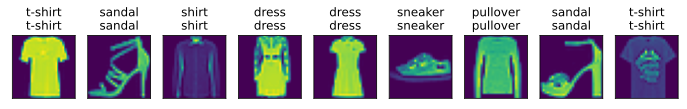

In [20]:
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.nn import init
import numpy as np
import torch.utils.data as Data

# 获取数据
batch_size = 256
mnist_train = torchvision.datasets.FashionMNIST(root='/Users/milktime/AnacondaProjects/deeplearning/Datasets/FashionMNIST', \
    train=True, download=False, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='/Users/milktime/AnacondaProjects/deeplearning/Datasets/FashionMNIST', \
    train=False, download=False, transform=transforms.ToTensor())

num_workers = 4

train_iter = Data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = Data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# 定义和初始化模型
# softmax 其实就是 全连接层，所以我们使用 线性网络层即可
# 每个样本x 的形状为 1 x 28 x 28，即 784大小的向量
num_inputs = 784
num_outputs = 10

# 定义 全连接网络层
class LinearNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
        self.weight = self.linear.weight
        self.bias = self.linear.bias
    def forward(self, x): # x shape: (batch, 1, 28, 28)
        # 前向传播函数，定义传播的规则
        y = self.linear(x.view(x.shape[0], -1))
        return y
# 如果需要自己实现 weight 和 bias
'''
self.weight = nn.Parameter(torch.empty((num_inputs, num_outputs))
self.bias = nn.Parameter(torch.empty(num_outputs)
'''
# 定义 数据处理层，将二为图片展开
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x):
        return x.view(x.shape[0], -1)

from collections import OrderedDict
# OrderedDict dict子类，保存添加元素的顺序

# 定义网络
net = nn.Sequential(
    OrderedDict([
        ('linear', LinearNet(num_inputs, num_outputs))
    ])
)

# # 或者以下面这种形式定义
# net = nn.Sequential(
#     OrderedDict([
#         ('flatten', FlattenLayer()), 
#         ('linear', nn.Linear(num_inputs, num_outputs))
#     ])
# )

# 初始化参数
init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0)

# softmax 和 交叉熵损失函数
# nn.CrossEntropyLoss 包括 softmax + cross_entropy 数值稳定性更好
# 且 loss 已经将 一个batch内的 所有样本的loss 求和
loss = nn.CrossEntropyLoss()

# 定义梯度下降优化算法
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

# 评估 网络模型 net 上，测试集的准确率
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        y_hat = net(X)
        acc_sum += (y_hat.argmax(dim=1) == y).sum()
        n += X.shape[0]
    return acc_sum / n

# 训练模型
num_epochs = 5

for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        optimizer.zero_grad() # 清空梯度，相当于 net.zero_grad()
        l.backward() # 反向计算梯度，累加到各个参数中
        optimizer.step() # 根据各个参数的梯度 以及 优化算法 做优化

        train_l_sum += l.data
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += X.shape[0]
    test_acc = evaluate_accuracy(test_iter, net)
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))


from IPython import display
from matplotlib import pyplot as plt
# 下面两个函数画图相关
def use_svg_display():
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

# 将数值标签 转换为 相应的文本标签
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_fashion_mnist(images, labels):
    use_svg_display()
    # 这里的_ 表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

X, y = iter(test_iter).next()
true_labels = get_fashion_mnist_labels(y)
pred_labels = get_fashion_mnist_labels(net(X).argmax(dim=1))
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]
show_fashion_mnist(X[0:9], titles[0:9])